In [1]:
import os
import shutil
from glob import glob

import numpy as np
import tensorflow as tf
import pandas as pd

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_csv = pd.read_csv('faces_images/train_vision.csv', names=['filename','label'])
train_csv.shape

(5851, 2)

In [3]:
test_csv= pd.read_csv('faces_images/test_vision.csv', names=['filename'])
test_csv.shape

(2001, 1)

In [4]:
train_dict = {}

In [5]:
for index in range(1,len(train_csv)) :
    train_dict[train_csv.filename[index]] = int(train_csv.label[index])

In [6]:
test_list=[]
for index in range(1,len(test_csv)):
        test_list.append(test_csv.filename[index])

In [7]:
dataset_path = "faces_images/datasets"
origin_path = 'faces_images/faces_images'
copy_path = 'faces_images/datasets'

In [8]:
def check_dir(path):
    if not os.path.isdir(path):
        os.makedirs(path)

In [9]:
def copy_files():
    check_dir(dataset_path)
    #train , valid데이터셋 
    train_paths = [os.path.join(origin_path,str(train_csv.filename[i])) for i in range(1,len(train_dict) +1)]
    
    for cnt, train_path in enumerate(train_paths):
        split = train_path.split('\\')
        if cnt < 3000:
            train_folder = os.path.join(dataset_path,'train')
            check_dir(train_folder)

            target_copy_paths = os.path.join(copy_path,'train',str(train_dict[split[-1]]))
            check_dir(target_copy_paths)
            
            shutil.copy(train_path, target_copy_paths)
        
        else:
            valid_folder = os.path.join(dataset_path,'valid')
            check_dir(valid_folder)

            target_copy_paths = os.path.join(copy_path,'valid',str(train_dict[split[-1]]))
            check_dir(target_copy_paths)

            shutil.copy(train_path, target_copy_paths)
            
            
    #test 데이터셋
    test_paths = [os.path.join(origin_path,test_list[i]) for i in range(0,len(test_list))]
    
    for test_path in test_paths:
        split = test_path.split('\\')
        test_folder = os.path.join(dataset_path,'test')
        check_dir(test_folder)
        
        target_copy_paths = os.path.join(copy_path,'test')
        check_dir(target_copy_paths)

        shutil.copy(test_path, target_copy_paths)
            

In [10]:
#test와 train 데이터 구분
copy_files()

In [11]:
import os
from glob import glob

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten,Dropout, MaxPooling2D
from tensorflow.keras import datasets
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tqdm import tqdm_notebook

In [12]:
os.listdir('faces_images/datasets/train')

['1', '2', '3', '4', '5', '6']

In [13]:
path = glob('faces_images/datasets/train')

In [14]:
train_dir = 'faces_images/datasets/train'
valid_dir = 'faces_images/datasets/valid'


# Hyperparameter Tunning

In [15]:
epoch = 50
batch_size = 32

learning_rate = 0.001

decay = learning_rate/epoch

dropout_rate = 0.2

input_shape = (128,128,3)
num_classes = 6

train_len = 3000
valid_len = 2850

# Preprocess

In [16]:
#학습 이미지에 augmentation 적용
train_datagen = ImageDataGenerator(rescale=1./255)

#검증 및 테스트는 augmentation을 적용하지 않고 이미지 원본을 이용
valid_datagen = ImageDataGenerator(rescale = 1./255)

In [17]:
train_generator = train_datagen.flow_from_directory(
    directory = train_dir,
    shuffle = True,
    target_size = input_shape[:2],
    batch_size = batch_size,
)

Found 3000 images belonging to 6 classes.


In [18]:
validation_generator = valid_datagen.flow_from_directory(
    directory = valid_dir,
    target_size = input_shape[:2],
    batch_size = batch_size,
)

Found 2850 images belonging to 6 classes.


# 시각화

In [19]:
sample_traing_images, _ = next(train_generator)

In [20]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1,5,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr,axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

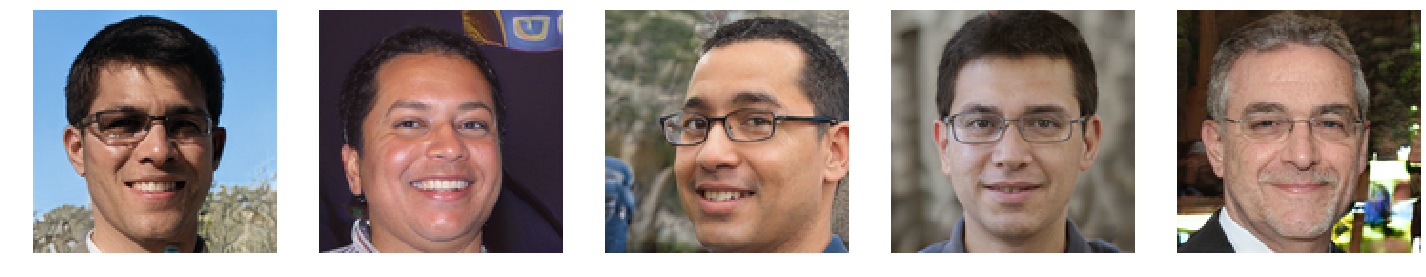

In [21]:
plotImages(sample_traing_images[:5])

# Build Model

In [22]:
model = Sequential([
    Conv2D(32,(3, 3), padding='same', activation='relu',input_shape= input_shape),
    Conv2D(32,(3, 3), padding='same', activation='relu',input_shape= input_shape),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(dropout_rate),
    
    Conv2D(64,(3, 3), padding='same', activation='relu'),
    Conv2D(64,(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size= (2,2)),
    Dropout(dropout_rate),
    
    Conv2D(128,(3, 3), padding='same', activation='relu'),
    Conv2D(128,(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(dropout_rate),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [23]:
sgd = SGD(lr = learning_rate, momentum=0.9 , decay = decay, nesterov= False)

In [24]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

In [26]:
len(train_generator)

94

In [27]:
model.fit_generator(
    train_generator,
    steps_per_epoch=train_len//batch_size, #한 에폭에 몇개의 배치가 얼마나 돌아야 한 에폭이 되는지
    epochs= epoch,
    #steps_per_epoch=10000, #한 에폭에 몇개의 배치가 얼마나 돌아야 한 에폭이 되는지
    validation_data= validation_generator,
    validation_steps= valid_len//batch_size
    #validation_steps= 4000
)

Epoch 1/50
93/93 [==============================] - ETA: 5:44 - loss: 1.7602 - accuracy: 0.12 - ETA: 5:19 - loss: 2.8371 - accuracy: 0.26 - ETA: 5:05 - loss: 2.6648 - accuracy: 0.35 - ETA: 5:01 - loss: 2.4223 - accuracy: 0.35 - ETA: 4:55 - loss: 2.2896 - accuracy: 0.34 - ETA: 4:48 - loss: 2.1888 - accuracy: 0.34 - ETA: 4:42 - loss: 2.0868 - accuracy: 0.35 - ETA: 4:38 - loss: 1.9973 - accuracy: 0.37 - ETA: 4:34 - loss: 1.9491 - accuracy: 0.39 - ETA: 4:30 - loss: 1.8978 - accuracy: 0.40 - ETA: 4:26 - loss: 1.8390 - accuracy: 0.41 - ETA: 4:22 - loss: 1.8052 - accuracy: 0.40 - ETA: 4:17 - loss: 1.7885 - accuracy: 0.40 - ETA: 4:14 - loss: 1.7682 - accuracy: 0.40 - ETA: 4:11 - loss: 1.7418 - accuracy: 0.42 - ETA: 4:08 - loss: 1.7223 - accuracy: 0.42 - ETA: 4:04 - loss: 1.7000 - accuracy: 0.43 - ETA: 4:01 - loss: 1.6827 - accuracy: 0.44 - ETA: 3:58 - loss: 1.6618 - accuracy: 0.44 - ETA: 3:55 - loss: 1.6674 - accuracy: 0.43 - ETA: 3:52 - loss: 1.6540 - accuracy: 0.44 - ETA: 3:49 - loss: 1.6441

93/93 [==============================] - ETA: 5:09 - loss: 1.4581 - accuracy: 0.40 - ETA: 5:04 - loss: 1.4393 - accuracy: 0.43 - ETA: 5:00 - loss: 1.4034 - accuracy: 0.40 - ETA: 4:57 - loss: 1.4070 - accuracy: 0.42 - ETA: 4:54 - loss: 1.3933 - accuracy: 0.43 - ETA: 4:52 - loss: 1.3679 - accuracy: 0.45 - ETA: 4:48 - loss: 1.3741 - accuracy: 0.44 - ETA: 4:43 - loss: 1.3881 - accuracy: 0.44 - ETA: 4:39 - loss: 1.3800 - accuracy: 0.45 - ETA: 4:34 - loss: 1.3837 - accuracy: 0.45 - ETA: 4:30 - loss: 1.3952 - accuracy: 0.45 - ETA: 4:26 - loss: 1.4124 - accuracy: 0.45 - ETA: 4:22 - loss: 1.3883 - accuracy: 0.46 - ETA: 4:18 - loss: 1.3928 - accuracy: 0.45 - ETA: 4:14 - loss: 1.3796 - accuracy: 0.46 - ETA: 4:10 - loss: 1.3666 - accuracy: 0.46 - ETA: 4:07 - loss: 1.3499 - accuracy: 0.47 - ETA: 4:03 - loss: 1.3531 - accuracy: 0.47 - ETA: 3:56 - loss: 1.3576 - accuracy: 0.47 - ETA: 3:53 - loss: 1.3689 - accuracy: 0.46 - ETA: 3:50 - loss: 1.3727 - accuracy: 0.46 - ETA: 3:46 - loss: 1.3772 - accuracy

93/93 [==============================] - ETA: 4:58 - loss: 1.2585 - accuracy: 0.56 - ETA: 4:54 - loss: 1.3407 - accuracy: 0.54 - ETA: 4:55 - loss: 1.2472 - accuracy: 0.59 - ETA: 4:53 - loss: 1.2328 - accuracy: 0.57 - ETA: 4:49 - loss: 1.3018 - accuracy: 0.53 - ETA: 4:45 - loss: 1.2896 - accuracy: 0.54 - ETA: 4:40 - loss: 1.2857 - accuracy: 0.53 - ETA: 4:36 - loss: 1.2849 - accuracy: 0.53 - ETA: 4:32 - loss: 1.2616 - accuracy: 0.54 - ETA: 4:29 - loss: 1.2836 - accuracy: 0.53 - ETA: 4:25 - loss: 1.3000 - accuracy: 0.51 - ETA: 4:22 - loss: 1.3128 - accuracy: 0.51 - ETA: 4:19 - loss: 1.3162 - accuracy: 0.50 - ETA: 4:15 - loss: 1.3069 - accuracy: 0.51 - ETA: 4:12 - loss: 1.3103 - accuracy: 0.51 - ETA: 4:09 - loss: 1.3081 - accuracy: 0.51 - ETA: 4:05 - loss: 1.3119 - accuracy: 0.51 - ETA: 4:02 - loss: 1.3056 - accuracy: 0.51 - ETA: 3:58 - loss: 1.2989 - accuracy: 0.52 - ETA: 3:55 - loss: 1.2924 - accuracy: 0.52 - ETA: 3:51 - loss: 1.2926 - accuracy: 0.52 - ETA: 3:48 - loss: 1.2840 - accuracy

KeyboardInterrupt: 

In [ ]:
save_path ='faces_images/my_model.h5'

In [ ]:
model.save(save_path, include_optimizer =True)

In [ ]:
m1 = load_model('faces_images/my_model.h5')

In [ ]:
m1.summary()

In [ ]:
def test_img_check (path):
    test_path = os.path.join('faces_images/datasets/test',path)
    gfile = tf.io.read_file(test_path)
    test_image = tf.io.decode_image(gfile,dtype=tf.float32)
    test_image = np.array(test_image)
    
    plt.imshow(test_image)
    plt.show()
    test_image/=32
    
    test_image = test_image.reshape((1,128,128,3))
    
    return m1.predict_classes(test_image)

In [ ]:
res_list = []
res_list.append('prediction')
for photo in tqdm_notebook(test_list):
    a = ((test_img_check((photo))))
    a = np.squeeze(a)

    res_list.append(a)

In [ ]:
res_list

In [ ]:
dataframe = pd.DataFrame(res_list)
dataframe.to_csv('faces_images/result.csv', header= False , index=False )

In [ ]:
dataframe

In [ ]:
os.listdir('faces_images')

In [ ]:
img = tf.io.read_file(test_img)
image = tf.io.decode_image(img,dtype=tf.float32)
#image /= 32

In [ ]:
image = np.array(image)

In [ ]:
image.shape
image/=32
image = image.reshape((1,128,128,3))
image.shape

In [ ]:
print('answer' , m1.predict_classes(image))

In [ ]:
test_list

In [ ]:
inputs = layers.Input(input_shape)

net = layers.Conv2D(32,(3,3),padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32,(3,3),padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2,2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(32,(3,3),padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32,(3,3),padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2,2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name= 'Basic_CNN')

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator), #한 에폭에 몇개의 배치가 얼마나 돌아야 한 에폭이 되는지
    validation_data= validation_generator,
    validation_steps= len(validation_generator)
)

In [ ]:
save_path ='faces_images/my_model.h5'

In [ ]:
model.save(save_path, include_optimizer =True)

In [ ]:
test_dir = 'faces_images/datasets/test'

In [ ]:
list_images = os.listdir(test_dir)

test_image = []

In [ ]:
for img in test_list:
    img_path = os.path.join(test_dir,img)
    
    gfile = tf.io.read_file(img_path)
    image = tf.io.decode_image(gfile,dtype=tf.float32)
    
    image /=255.
    
    test_image.append(image)

In [ ]:
image_array = np.array(test_image)

In [ ]:
image_array.shape